In [1]:
# mrac_siso_mit.py
# Johannes Kaisinger, 3 July 2023
#
# Demonstrate a MRAC example for a SISO plant using MIT rule.
# Based on [1] Ex 5.2, Fig 5.5 & 5.6.
# Notation as in [2].
#
# [1] K. J. Aström & B. Wittenmark "Adaptive Control" Second Edition, 2008.
#
# [2] Nhan T. Nguyen "Model-Reference Adaptive Control", 2018.

import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import os

import control as ct

In [ ]:
ct.NonlinearIOSystem

Optimal value for kr_star = 4.0
Optimal value for kx_star = -2.0


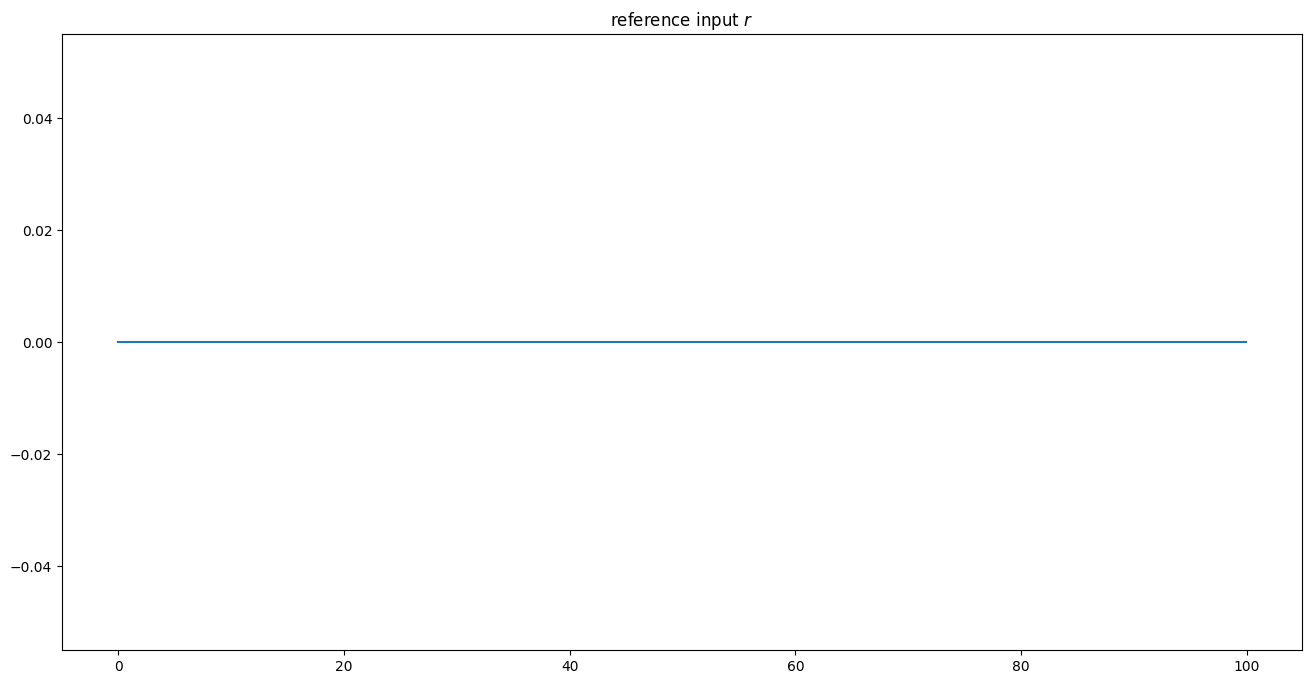

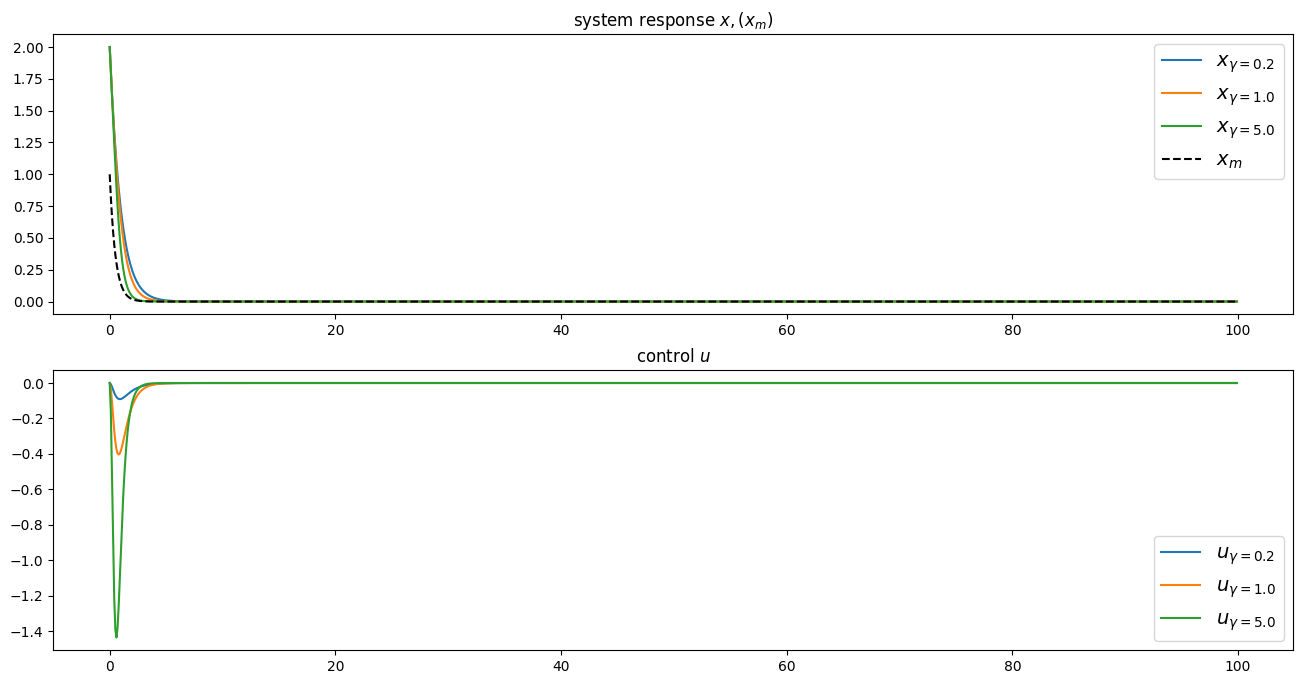

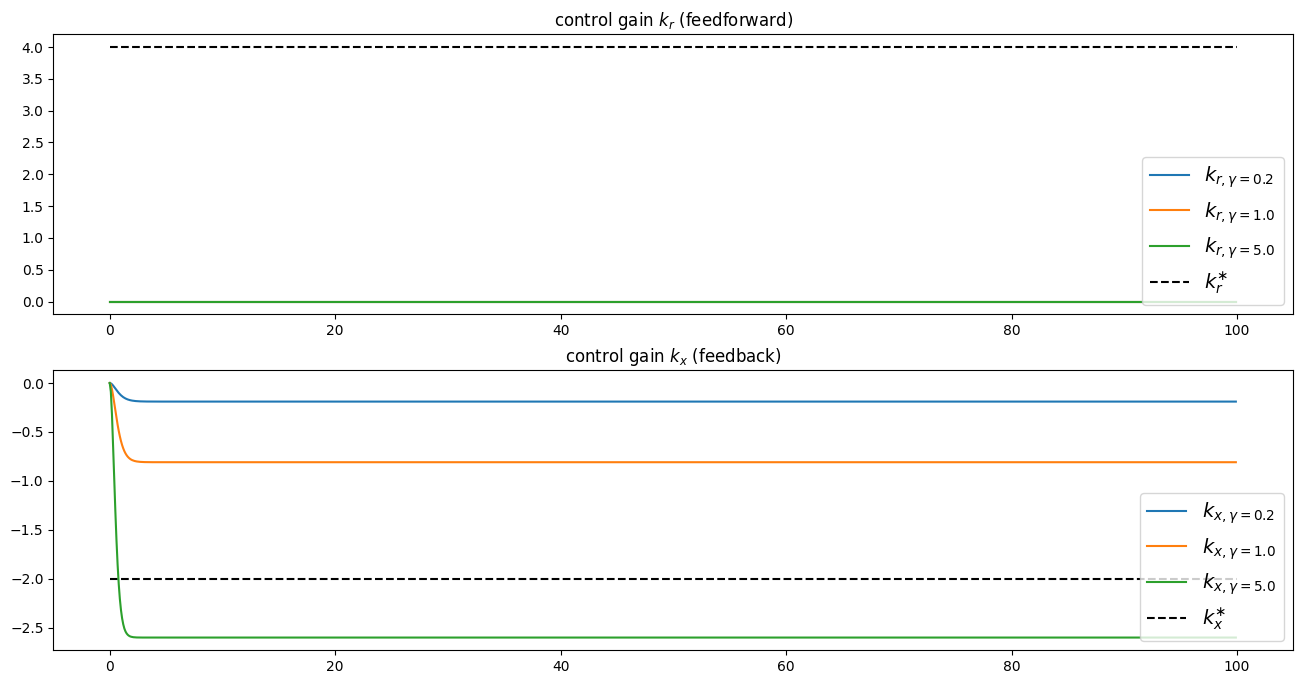

In [6]:

# Plant model as linear state-space system
A = -1.
B = 0.5
C = 1
D = 0

io_plant = ct.ss(A, B, C, D,
                 inputs=('u'), outputs=('x'), states=('x'), name='plant')

# Reference model as linear state-space system
Am = -2
Bm = 2
Cm = 1
Dm = 0

io_ref_model = ct.ss(Am, Bm, Cm, Dm,
                     inputs=('r'), outputs=('xm'), states=('xm'), name='ref_model')

# Adaptive control law, u = kx*x + kr*r
kr_star = (Bm)/B
print(f"Optimal value for {kr_star = }")
kx_star = (Am-A)/B
print(f"Optimal value for {kx_star = }")

def adaptive_controller_state(t, xc, uc, params):
    """Internal state of adaptive controller, f(t,x,u;p)"""
    
    # Parameters
    gam = params["gam"]
    Am = params["Am"]
    Bm = params["Bm"]
    signB = params["signB"]

    # Controller inputs
    r = uc[0]
    xm = uc[1]
    x = uc[2]

    # Controller states
    x1 = xc[0] #
    # x2 = xc[1] # kr
    x3 = xc[2] #
    # x4 = xc[3] # kx
    
    # Algebraic relationships
    e = xm - x

    # Controller dynamics
    d_x1 = Am*x1 + Am*r
    d_x2 = - gam*x1*e*signB
    d_x3 = Am*x3 + Am*x
    d_x4 = - gam*x3*e*signB

    return [d_x1, d_x2, d_x3, d_x4]

def adaptive_controller_output(t, xc, uc, params):
    """Algebraic output from adaptive controller, g(t,x,u;p)"""

    # Controller inputs
    r = uc[0]
    # xm = uc[1]
    x = uc[2]
    
    # Controller state
    kr = xc[1]
    kx = xc[3]
    
    # Control law
    u = kx*x + kr*r

    return [u]

params={"gam":1, "Am":Am, "Bm":Bm, "signB":np.sign(B)}

io_controller = ct.NonlinearIOSystem(
    adaptive_controller_state,
    adaptive_controller_output,
    inputs=('r', 'xm', 'x'),
    outputs=('u'),
    states=4,
    params=params,
    name='control',
    dt=0
)

# Overall closed loop system
io_closed = ct.interconnect(
    [io_plant, io_ref_model, io_controller],
    connections=[
        ['plant.u', 'control.u'],
        ['control.xm', 'ref_model.xm'],
        ['control.x', 'plant.x']
    ],
    inplist=['control.r', 'ref_model.r'],
    outlist=['plant.x', 'control.u'],
    dt=0
)

# Set simulation duration and time steps
Tend = 100
dt = 0.1

# Define simulation time 
t_vec = np.arange(0, Tend, dt)

# Define control reference input
r_vec = np.zeros((2, len(t_vec)))
square = np.zeros(t_vec.shape)
#signal.square(2 * np.pi * 0.05 * t_vec)
r_vec[0, :] = square
r_vec[1, :] = r_vec[0, :]

plt.figure(figsize=(16,8))
plt.plot(t_vec, r_vec[0,:])
plt.title(r'reference input $r$')
plt.show()

# Set initial conditions, io_closed
X0 = np.zeros((6, 1))
X0[0] = 2 # state of plant, (x)
X0[1] = 1 # state of ref_model, (xm)
X0[2] = 0 # state of controller,
X0[3] = 0 # state of controller, (kr)
X0[4] = 0 # state of controller,
X0[5] = 0 # state of controller, (kx)

# Simulate the system with different gammas
tout1, yout1, xout1 = ct.input_output_response(io_closed, t_vec, r_vec, X0,
                                               return_x=True, params={"gam":0.2})
tout2, yout2, xout2 = ct.input_output_response(io_closed, t_vec, r_vec, X0,
                                               return_x=True, params={"gam":1.0})
tout3, yout3, xout3 = ct.input_output_response(io_closed, t_vec, r_vec, X0,
                                               return_x=True, params={"gam":5.0})

plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(tout1, yout1[0,:], label=r'$x_{\gamma = 0.2}$')
plt.plot(tout2, yout2[0,:], label=r'$x_{\gamma = 1.0}$')
plt.plot(tout2, yout3[0,:], label=r'$x_{\gamma = 5.0}$')
plt.plot(tout1, xout1[1,:] ,label=r'$x_{m}$', color='black', linestyle='--')
plt.legend(fontsize=14)
plt.title(r'system response $x, (x_m)$')
plt.subplot(2,1,2)
plt.plot(tout1, yout1[1,:], label=r'$u_{\gamma = 0.2}$')
plt.plot(tout2, yout2[1,:], label=r'$u_{\gamma = 1.0}$')
plt.plot(tout3, yout3[1,:], label=r'$u_{\gamma = 5.0}$')
plt.legend(loc=4, fontsize=14)
plt.title(r'control $u$')

plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(tout1, xout1[3,:], label=r'$k_{r, \gamma = 0.2}$')
plt.plot(tout2, xout2[3,:], label=r'$k_{r, \gamma = 1.0}$')
plt.plot(tout3, xout3[3,:], label=r'$k_{r, \gamma = 5.0}$')
plt.hlines(kr_star, 0, Tend, label=r'$k_r^{\ast}$', color='black', linestyle='--')
plt.legend(loc=4, fontsize=14)
plt.title(r'control gain $k_r$ (feedforward)')
plt.subplot(2,1,2)
plt.plot(tout1, xout1[5,:], label=r'$k_{x, \gamma = 0.2}$')
plt.plot(tout2, xout2[5,:], label=r'$k_{x, \gamma = 1.0}$')
plt.plot(tout3, xout3[5,:], label=r'$k_{x, \gamma = 5.0}$')
plt.hlines(kx_star, 0, Tend, label=r'$k_x^{\ast}$', color='black', linestyle='--')
plt.legend(loc=4, fontsize=14)
plt.title(r'control gain $k_x$ (feedback)')

if 'PYCONTROL_TEST_EXAMPLES' not in os.environ:
    plt.show()